<a href="https://colab.research.google.com/github/AaliyanShuja/SalesPrediction/blob/main/SalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from   scipy.stats import f_oneway
from   scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from   statsmodels.stats.outliers_influence import variance_inflation_factor
from   statsmodels.stats.multicomp import pairwise_tukeyhsd
import lightgbm as lgb
from   prophet import Prophet
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import mean_squared_error, r2_score
from   sklearn.preprocessing import StandardScaler, MinMaxScaler
from   sklearn.linear_model import LinearRegression
from   datetime import datetime
import dask.dataframe as dd
from   google.colab import data_table
data_table.disable_dataframe_formatter()

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install "dask[dataframe]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/women_clothing_ecommerce_sales.csv')
df.head()

,order_id,order_date,sku,color,size,unit_price,quantity,revenue
0,1,2022/6/1 16:05:00,708,Dark Blue,2XL,298,1,298
1,1,2022/6/1 16:05:00,89,Dark Blue,2XL,258,1,258
2,2,2022/6/10 17:03:00,bobo,Cream,One Size,228,1,228
3,3,2022/6/10 19:59:00,799,Dark Blue,XL,264,1,264
4,4,2022/6/11 11:42:00,799,Dark Blue,M,264,1,264


In [ ]:
df.describe()

,order_id,unit_price,quantity,revenue
count,527.000000,527.000000,527.000000,527.000000
mean,115.313093,274.973435,1.011385,278.024668
std,73.106716,34.517412,0.106193,44.741095
min,1.000000,191.000000,1.000000,191.000000
25%,54.000000,266.000000,1.000000,266.000000
50%,110.000000,278.000000,1.000000,278.000000
75%,166.000000,288.000000,1.000000,288.000000
max,273.000000,899.000000,2.000000,899.000000


In [ ]:
# Checking the missing values
print("Missing values per column:\n", df.isnull().sum())

# Filling the missing numeric columns with their median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

Missing values per column:
 order_id       0
order_date     0
sku            0
color          0
size          37
unit_price     0
quantity       0
revenue        0
dtype: int64


In [ ]:
# Removing the duplicates
df = df.drop_duplicates()
print(f"Shape after the duplicates removed is: {df.shape}")

Shape after the duplicates removed is: (527, 8)


In [ ]:
# Defining the function to remove outliers based on IQR
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound  = Q1 - 1.5 * IQR
    upper_bound  = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

# Apply the function to numeric columns
for col in numeric_cols:
    df = remove_outliers_iqr (df, col)

print(f"Shape after removing outliers: {df.shape}")


Shape after removing outliers: (494, 8)


In [ ]:
cleaned_file_path = "/content/women_clothing_ecommerce_sales.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")

Cleaned data saved to /content/women_clothing_ecommerce_sales.csv


In [ ]:
print(df.describe())

# Values for the categoruical columns
print(df['color'].value_counts())
print(df['size'].value_counts())

         order_id  unit_price  quantity     revenue
count  494.000000  494.000000     494.0  494.000000
mean   117.759109  277.070850       1.0  277.070850
std     72.696099   15.592199       0.0   15.592199
min      1.000000  238.000000       1.0  238.000000
25%     56.000000  266.000000       1.0  266.000000
50%    113.500000  278.000000       1.0  278.000000
75%    168.750000  288.000000       1.0  288.000000
max    273.000000  318.000000       1.0  318.000000
color
Dark Blue        392
Light Blue        24
Black             13
Grey Wash          9
B                  6
Mid Wash           6
Dark Wash          5
C                  4
Navy Blue          4
Rust               3
Gray               3
Thin Blue          3
A                  3
Blue Stripes       2
D                  2
Brown              2
Green              2
Mustard            1
Mocha              1
Skintone           1
Gray Stripes       1
White              1
Black Stripes      1
Blue               1
Light Wash         1
T

In [ ]:
import pandas as pd

 # Converting the  order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

 # Extracting the time-based features
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek
df['day'] = df['order_date'].dt.day

print(df.head())

   order_id          order_date  sku      color size  unit_price  quantity  \
0         1 2022-06-01 16:05:00  708  Dark Blue  2XL         298         1   
1         1 2022-06-01 16:05:00   89  Dark Blue  2XL         258         1   
3         3 2022-06-10 19:59:00  799  Dark Blue   XL         264         1   
4         4 2022-06-11 11:42:00  799  Dark Blue    M         264         1   
5         5 2022-06-11 14:46:00  799  Dark Blue   XL         264         1   

   revenue  year  month  day_of_week  day  
0      298  2022      6            2    1  
1      258  2022      6            2    1  
3      264  2022      6            4   10  
4      264  2022      6            5   11  
5      264  2022      6            5   11  


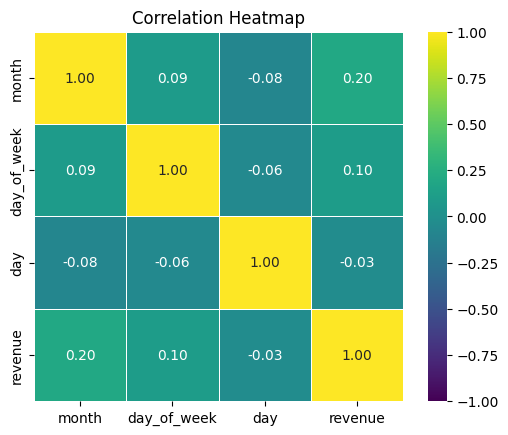

In [ ]:
correlation_matrix = df[['month', 'day_of_week','day', 'revenue']].corr()

#using heatmaps
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Average revenue of month
monthly_revenue = df.groupby('month')['revenue'].mean()
print(monthly_revenue)

# Average revenue of week days
weekday_revenue = df.groupby('day_of_week')['revenue'].mean()
print(weekday_revenue)

# Average revenue of days
daily_revenue = df.groupby('day')['revenue'].mean()
print(daily_revenue)

month
6    271.965909
7    278.275229
8    273.090909
9    282.831169
Name: revenue, dtype: float64
day_of_week
0    274.024691
1    279.865385
2    276.507463
3    274.357143
4    274.870130
5    278.307692
6    281.457831
Name: revenue, dtype: float64
day
1     278.857143
2     293.000000
3     283.222222
4     291.818182
5     282.750000
6     276.740741
7     272.294118
8     274.416667
9     267.727273
10    276.636364
11    271.058824
12    277.571429
13    270.833333
14    275.266667
15    265.971429
16    279.823529
17    275.777778
18    285.777778
19    285.166667
20    286.750000
21    279.700000
22    278.769231
23    272.833333
24    276.923077
25    274.000000
26    269.052632
27    277.285714
28    289.166667
29    285.818182
30    272.428571
31    280.692308
Name: revenue, dtype: float64


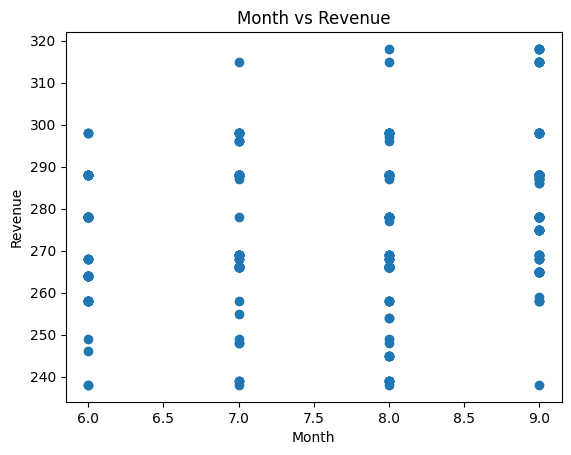

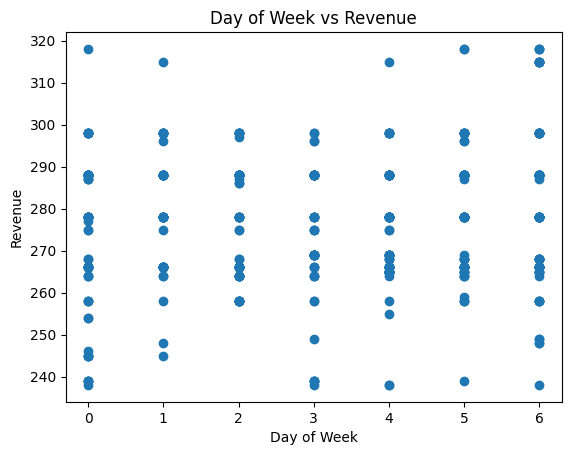

In [ ]:
# Scatter plot for month vs. revenue
plt.scatter(df['month'], df['revenue'])
plt.title('Month vs Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

# Scatter plot for day_of_week vs. revenue
plt.scatter(df['day_of_week'], df['revenue'])
plt.title('Day of Week vs Revenue')
plt.xlabel('Day of Week')
plt.ylabel('Revenue')
plt.show()

In [ ]:
# Add holiday flags (manually or using a calendar library)
df['is_holiday'] = df['order_date'].isin(['2024-12-25', '2024-11-23'])

# Analyze correlation with holidays
holiday_revenue = df.groupby('is_holiday')['revenue'].mean()
print(holiday_revenue)

is_holiday
False    277.07085
Name: revenue, dtype: float64


<ipython-input-14-54eaf9d3778a>:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['order_date'].isin(['2024-12-25', '2024-11-23'])


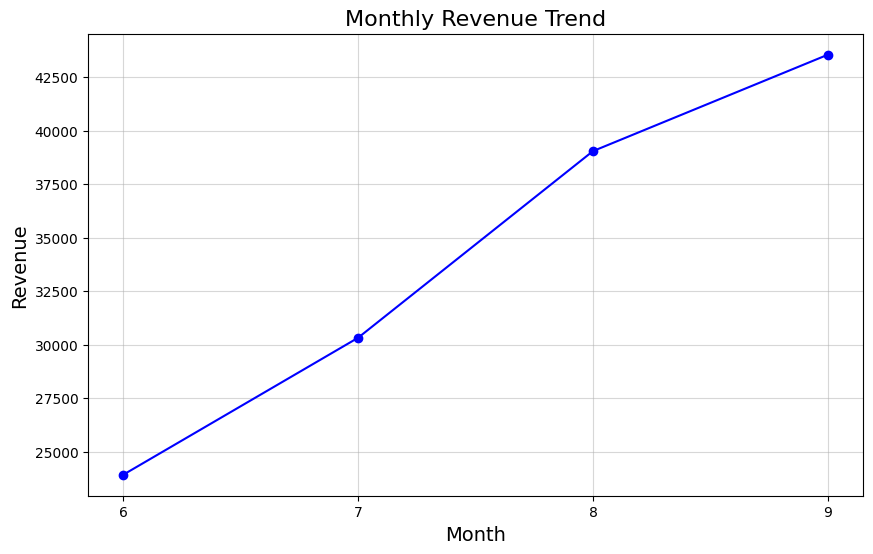

In [ ]:
# The dataset is already loaded into a DataFrame 'df'
# Extracting 'month' and 'revenue' for plotting
monthly_revenue = df.groupby('month')['revenue'].sum().reset_index()

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot ( monthly_revenue['month'],  monthly_revenue['revenue'], marker='o', linestyle='-', color='blue')
plt.title ('Monthly Revenue Trend', fontsize=16)
plt.xlabel ('Month', fontsize=14)
plt.ylabel ('Revenue', fontsize=14)
plt.xticks ( monthly_revenue['month'])  # Setting x-axis ticks to month values
plt.grid ( alpha=0.5 )
plt.show()

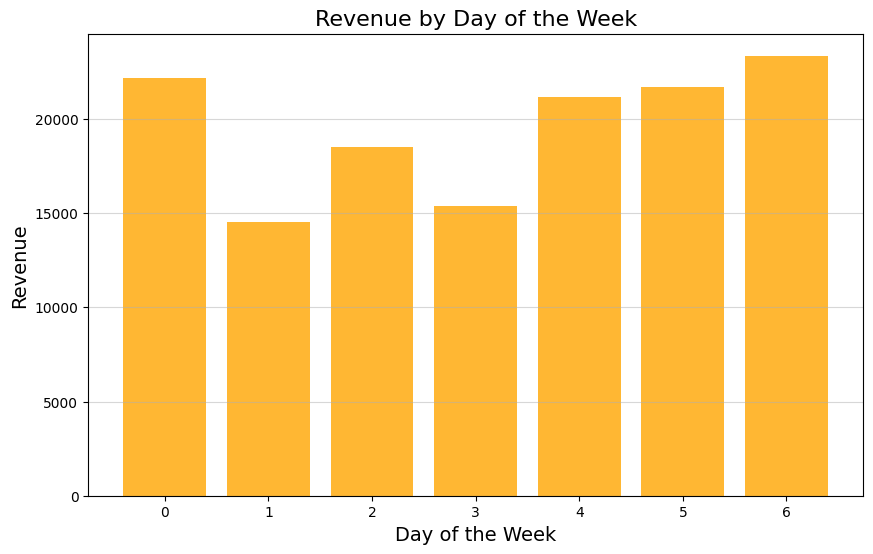

In [ ]:

# Taking the dataset for the datafrane 'df'
# Grouping revenue by the day of the week
day_of_week_revenue = df.groupby('day_of_week')['revenue'].sum().reset_index()

# Plotting the bar chart
plt.figure (figsize=(10, 6))
plt.bar (day_of_week_revenue['day_of_week'] , day_of_week_revenue['revenue'], color='orange', alpha=0.8)
plt.title ('Revenue by Day of the Week', fontsize=16)
plt.xlabel ('Day of the Week', fontsize=14)
plt.ylabel ('Revenue', fontsize=14)
plt.xticks (day_of_week_revenue['day_of_week'])  # Adjust tick labels
plt.grid ( axis='y', alpha=0.5 )
plt.show()

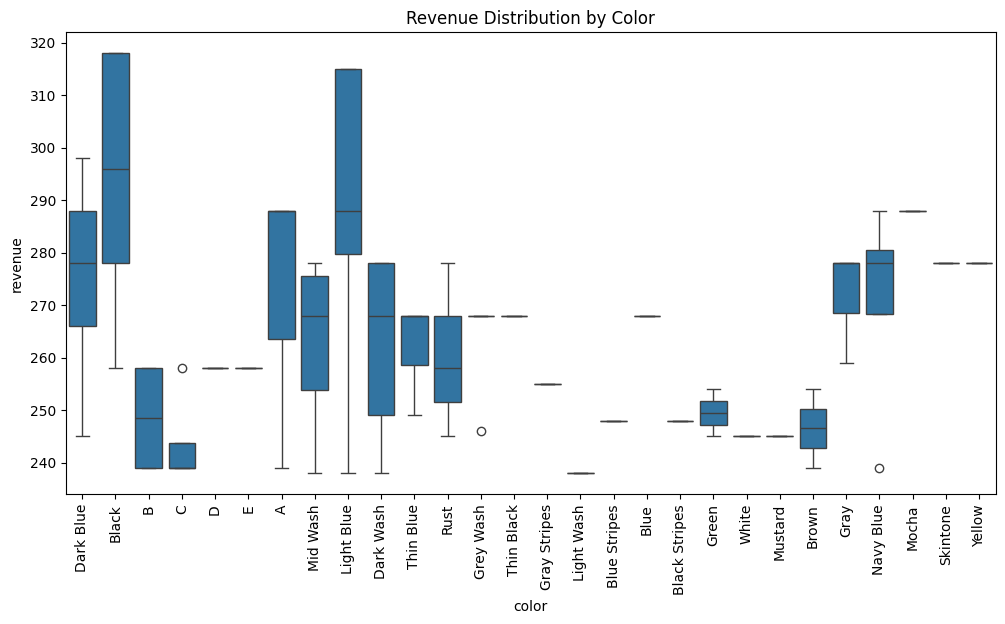

In [ ]:
# Box plot the distribution of revenue across different colors
plt.figure ( figsize=(12, 6))
sns.boxplot ( data=df, x='color', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ( 'Revenue Distribution by Color')
plt.show()

In [ ]:
color_revenue_avg = df.groupby('color')['revenue'].mean().reset_index()

# Displaying  the average revenue by color
print(color_revenue_avg)

            color     revenue
0               A  271.666667
1               B  248.500000
2           Black  296.307692
3   Black Stripes  248.000000
4            Blue  268.000000
5    Blue Stripes  248.000000
6           Brown  246.500000
7               C  243.750000
8               D  258.000000
9       Dark Blue  278.589286
10      Dark Wash  262.200000
11              E  258.000000
12           Gray  271.666667
13   Gray Stripes  255.000000
14          Green  249.500000
15      Grey Wash  265.555556
16     Light Blue  288.166667
17     Light Wash  238.000000
18       Mid Wash  263.166667
19          Mocha  288.000000
20        Mustard  245.000000
21      Navy Blue  270.750000
22           Rust  260.333333
23       Skintone  278.000000
24     Thin Black  268.000000
25      Thin Blue  261.666667
26          White  245.000000
27         Yellow  278.000000


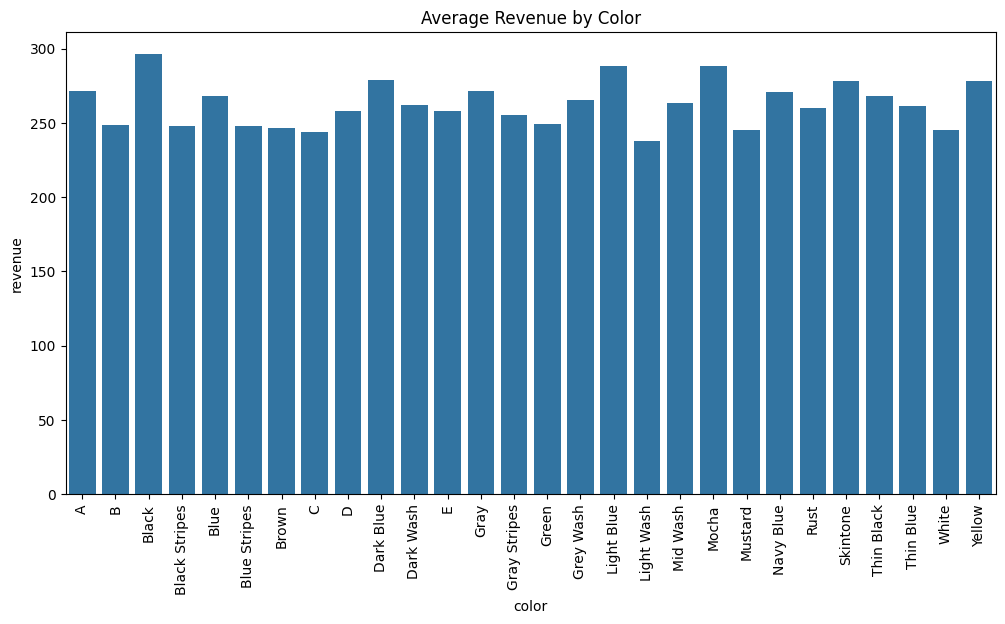

In [ ]:
# Using Bar plot for the average revenue by color
plt.figure (figsize=(12, 6))
sns.barplot ( data=color_revenue_avg, x='color', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ('Average Revenue by Color')
plt.show()

In [ ]:
from scipy.stats import f_oneway

# Performing the ANOVA to test if the revenue differs by color
colors = df['color'].unique()
grouped_revenue = [df[df['color'] == color]['revenue'] for color in colors]
anova_result = f_oneway(*grouped_revenue)

# Displaying the result of the ANOVA test
print ("ANOVA test result:", anova_result)

ANOVA test result: F_onewayResult(statistic=7.040598745044801, pvalue=1.694161309451149e-21)


In [ ]:
# Perfoming it to get check the variance difference between revenue and color
model = smf.ols('revenue ~ C(color)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['revenue'], groups=df['color'], alpha=0.05)
print(tukey)

                sum_sq     df         F        PR(>F)
C(color)  34727.020457   27.0  7.040599  1.694161e-21
Residual  85129.499786  466.0       NaN           NaN
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------
            A             B -23.1667 0.7995  -58.8915  12.5581  False
            A         Black   24.641 0.4761   -7.7193  57.0013  False
            A Black Stripes -23.6667 0.9995   -82.005  34.6717  False
            A          Blue  -3.6667    1.0   -62.005  54.6717  False
            A  Blue Stripes -23.6667  0.982  -69.7872  22.4538  False
            A         Brown -25.1667  0.962  -71.2872  20.9538  False
            A             C -27.9167 0.5908  -66.5038  10.6705  False
            A             D -13.6667    1.0  -59.7872  32.4538  False
            A     Dark Blue   6.9226    1.0   -22.358  36.2032  Fals

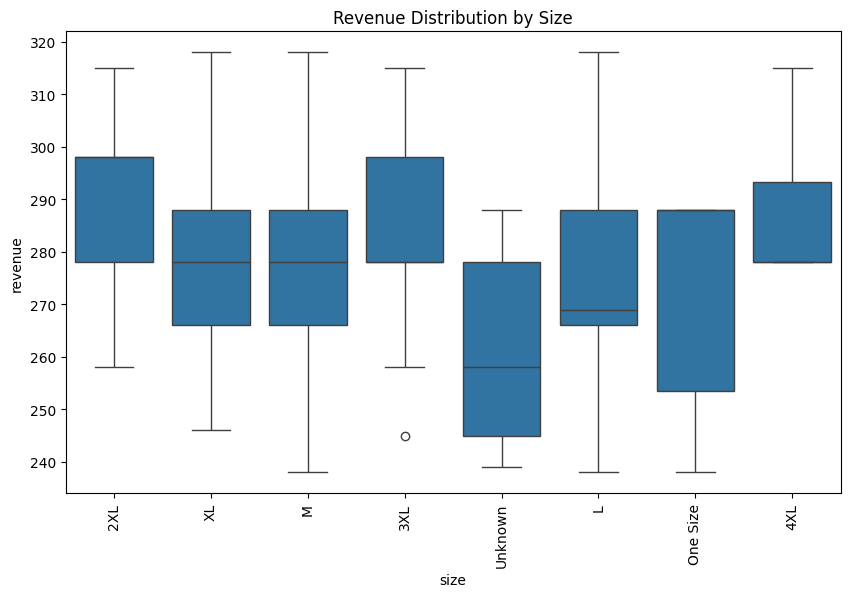

In [ ]:
# Box plot for visualizing the distribution of revenue across different sizes
plt.figure ( figsize=(10, 6))
sns.boxplot ( data=df, x='size', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ('Revenue Distribution by Size')
plt.show()

In [ ]:
# Calculating the average revenue per size
size_revenue_avg = df.groupby('size')['revenue'].mean().reset_index()

# Displaying the average revenue by size
print (size_revenue_avg)

       size     revenue
0       2XL  288.883721
1       3XL  282.525000
2       4XL  288.250000
3         L  275.400000
4         M  277.797753
5  One Size  272.214286
6   Unknown  259.351351
7        XL  277.459119


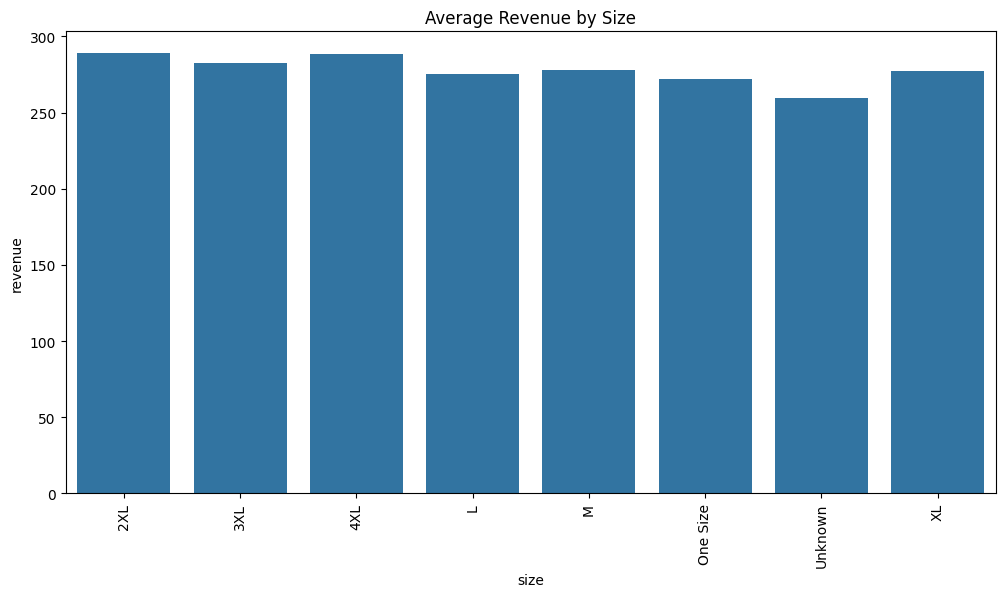

In [ ]:
# Bar plot for average revenue by size
plt.figure (figsize=(12, 6))
sns.barplot (data=size_revenue_avg, x='size', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ( 'Average Revenue by Size')
plt.show()

In [ ]:
# Performing the ANOVA to test if the revenue differs by size
sizes = df['size'].unique()
grouped_revenue = [df[df['size'] == size]['revenue'] for size in sizes]
anova_result = f_oneway(*grouped_revenue)

# Display the result of the ANOVA test
print("ANOVA test result:", anova_result)

ANOVA test result: F_onewayResult(statistic=14.570240563766182, pvalue=2.9169125115079527e-17)


<ipython-input-26-0d141e04e4b7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot (x=size_revenue_avg['size'], y=size_revenue_avg['revenue'], palette="viridis")


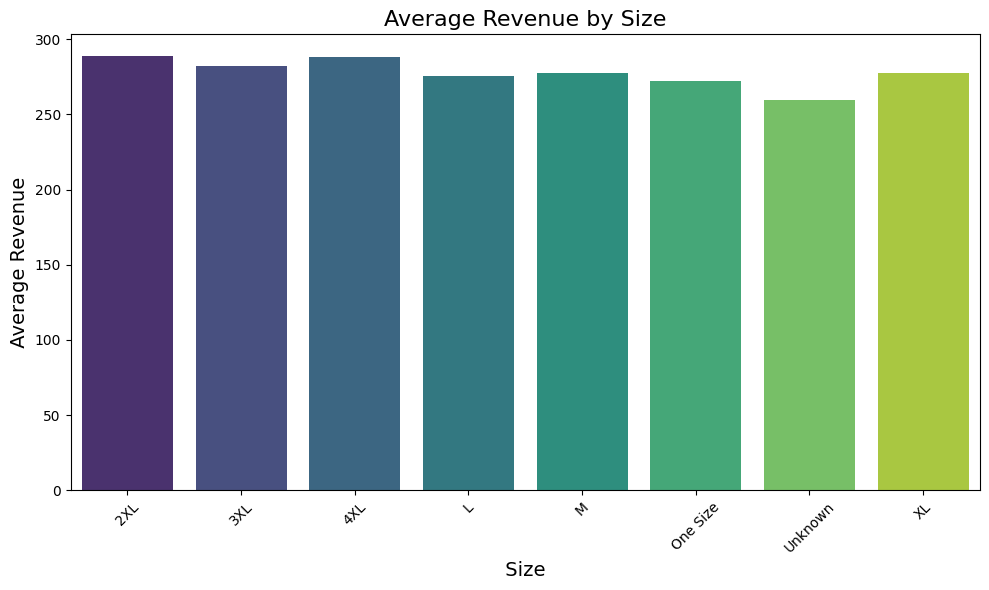

revenue          1.000000
size_3XL         0.103935
size_4XL         0.092081
size_M           0.021876
size_XL          0.017173
size_L          -0.050629
size_One Size   -0.076427
size_Unknown    -0.323688
Name: revenue, dtype: float64


In [ ]:
# Visualization: Bar plot of revenue by size
plt.figure ( figsize=(10, 6))
# Using the size average mean
sns.barplot (x=size_revenue_avg['size'], y=size_revenue_avg['revenue'], palette="viridis")
plt.title ( 'Average Revenue by Size', fontsize=16)
plt.xlabel ( ' Size ', fontsize=14 )
plt.ylabel (' Average Revenue ' , fontsize=14)
plt.xticks ( rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis (one-hot encode size to compute Pearson correlation)
size_encoded =  pd.get_dummies (df['size'], prefix='size', drop_first=True)
size_encoded['revenue'] =  df['revenue']
correlation_with_revenue =  size_encoded.corr()['revenue'].sort_values(ascending=False)

print(correlation_with_revenue)

In [ ]:
# Perfoming Tukey's HSD to check the significance in between revenue and size
model = smf.ols('revenue ~ C(size)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['revenue'], groups=df['size'], alpha=0.05)
print(tukey)

                sum_sq     df          F        PR(>F)
C(size)   20790.036093    7.0  14.570241  2.916913e-17
Residual  99066.484150  486.0        NaN           NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
     2XL      3XL  -6.3587 0.4643 -15.9062   3.1888  False
     2XL      4XL  -0.6337    1.0 -17.3686  16.1011  False
     2XL        L -13.4837    0.0  -21.541  -5.4265   True
     2XL        M  -11.086 0.0009 -19.1578  -3.0141   True
     2XL One Size -16.6694 0.0001 -27.2238  -6.1151   True
     2XL  Unknown -29.5324    0.0 -39.2784 -19.7864   True
     2XL       XL -11.4246 0.0001 -18.8953  -3.9539   True
     3XL      4XL    5.725 0.9689  -11.108   22.558  False
     3XL        L   -7.125 0.1491 -15.3842   1.1342  False
     3XL        M  -4.7272 0.6613 -13.0007   3.5462  False
     3XL One Size -10.3107 0.0688   -21.02   0.3986  False
     3XL 

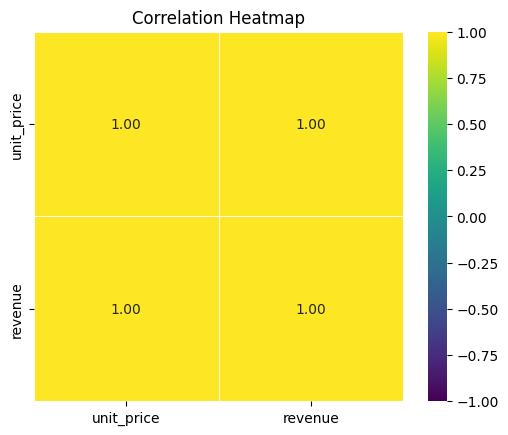

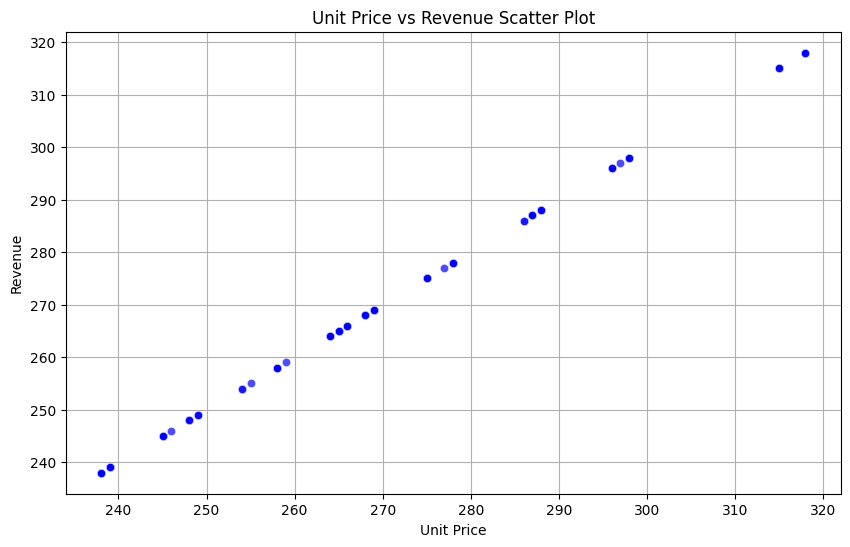

In [ ]:
# Finding the correlation between unit_price and revenue
correlation_matrix = df[['unit_price', 'revenue']].corr()

#using heatmaps
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


#Scatter plot for unit_price vs revenue
plt.figure (figsize=(10, 6))
sns.scatterplot (data=df, x='unit_price', y='revenue', color='blue', alpha=0.7)
plt.title ("Unit Price vs Revenue Scatter Plot")
plt.xlabel ("Unit Price")
plt.ylabel ("Revenue")
plt.grid (True)
plt.show()

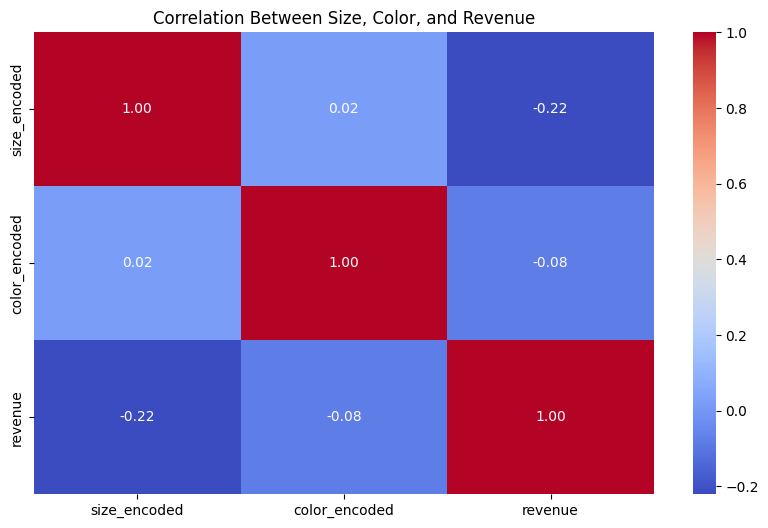

In [ ]:
df['size_encoded'] = df['size'].astype('category').cat.codes
df['color_encoded'] = df['color'].astype('category').cat.codes

# Correlation between size, color, and revenue
size_color_revenue_correlation = df[['size_encoded', 'color_encoded', 'revenue']].corr()

# Visualizing the correlation using a heatmap
plt.figure (figsize=(10,6))
sns.heatmap (size_color_revenue_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title ("Correlation Between Size, Color, and Revenue")
plt.show()


   order_id  revenue  quantity  unit_price          order_date  \
0         1      556         2       278.0 2022-06-01 16:05:00   
1         2      245         1       245.0 2022-08-30 09:42:00   
2         3      542         2       271.0 2022-06-10 19:59:00   
3         4      542         2       271.0 2022-06-11 11:42:00   
4         5      542         2       271.0 2022-06-11 14:46:00   

   avg_revenue_per_item  
0                 278.0  
1                 245.0  
2                 271.0  
3                 271.0  
4                 271.0  


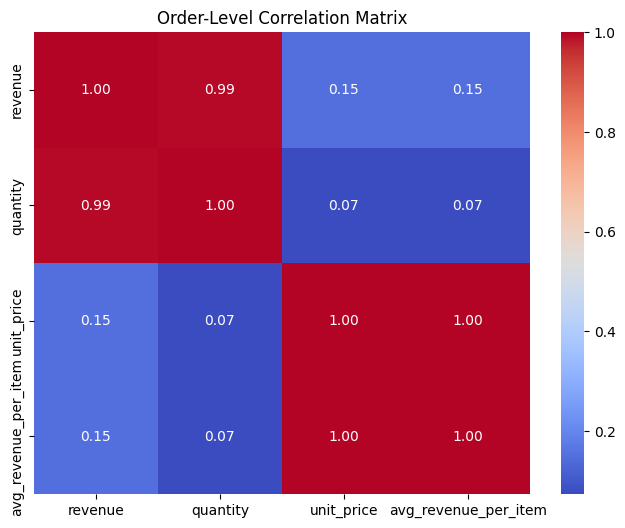

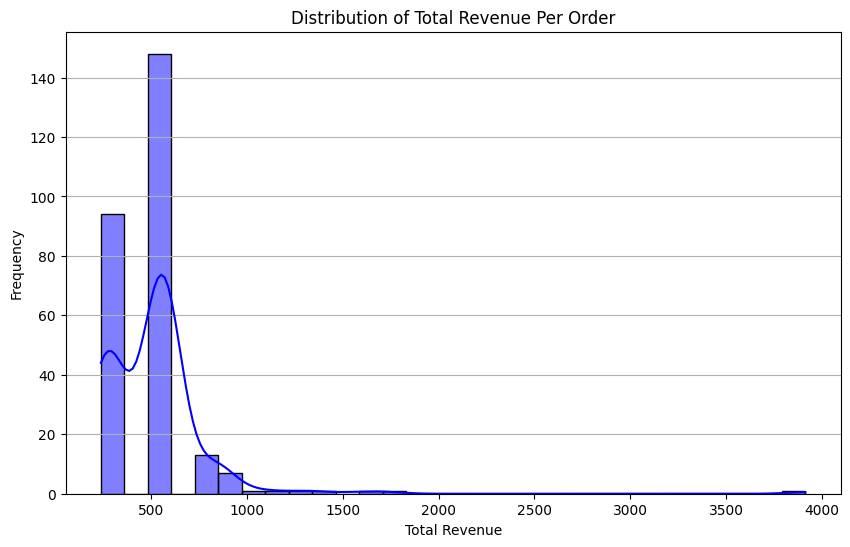

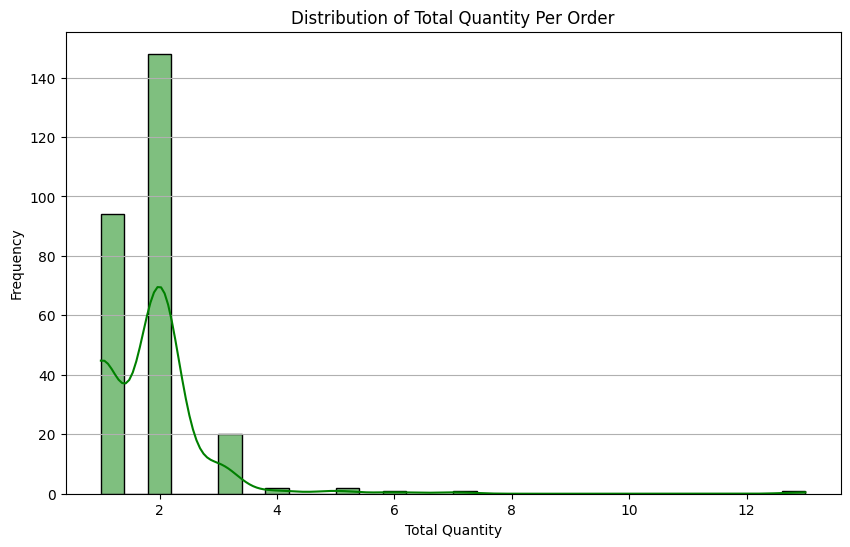

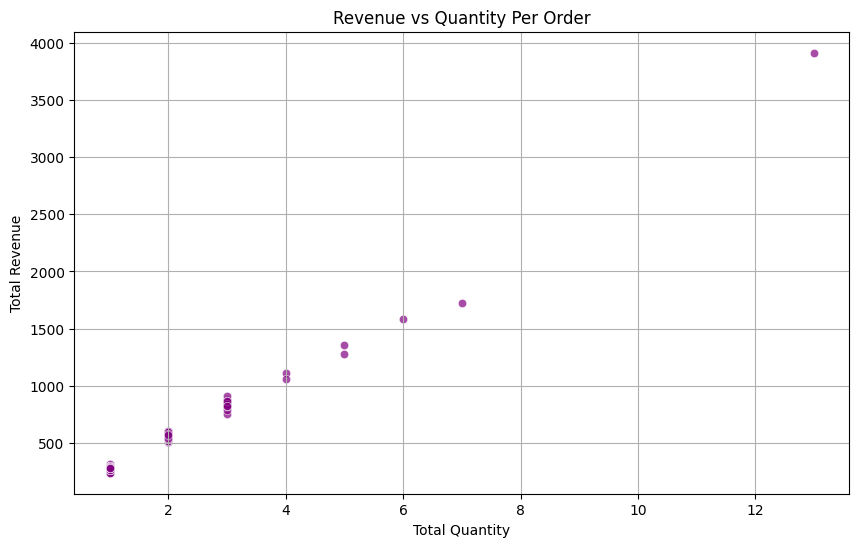

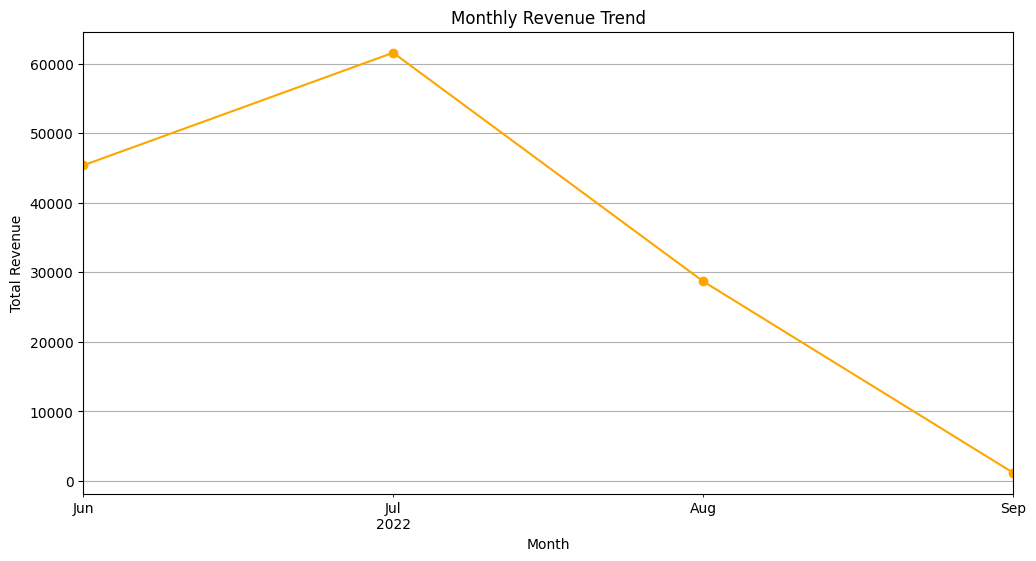

In [ ]:
# 1. Aggregating data at the order level
order_data = df.groupby('order_id').agg({
    'revenue': 'sum',               # Total revenue per order
    'quantity': 'sum',              # Total quantity per order
    'unit_price': 'mean',           # Average unit price per order
    'order_date': 'min'             # Order date (assuming one date per order_id)
}).reset_index()

# Adding  additional metrics like average revenue per item
# Removing extra spaces around the column name
order_data['avg_revenue_per_item'] = order_data['revenue'] / order_data['quantity']

# Displaying  the aggregated order-level data
print (order_data.head())

# 2. Correlation analysis at the order level
# Removing extra spaces around the column name
order_level_correlation  = order_data [['revenue', 'quantity', 'unit_price', 'avg_revenue_per_item']].corr()

# Visualize correlation matrix
plt.figure (figsize = (8, 6) )
sns.heatmap (order_level_correlation, annot=True, cmap='coolwarm', fmt=".2f" )
plt.title ( "Order-Level Correlation Matrix")
plt.show()
# 3. Revenue distribution across orders
plt.figure(figsize = ( 10, 6))
sns.histplot (order_data ['revenue'], bins=30, kde=True, color='blue' )
plt.title ("Distribution of Total Revenue Per Order")
plt.xlabel ("Total Revenue")
plt.ylabel ("Frequency")
plt.grid (axis='y')
plt.show()

# 4. Quantity distribution across orders
plt.figure (figsize = (10, 6))
sns.histplot ( order_data ['quantity'], bins=30 , kde=True, color='green')
plt.title ("Distribution of Total Quantity Per Order")
plt.xlabel ("Total Quantity")
plt.ylabel ("Frequency")
plt.grid (axis='y')
plt.show()

# 5. Analyze revenue vs quantity at the order level
plt.figure(figsize = (10, 6))
sns.scatterplot (data=order_data, x ='quantity', y='revenue', alpha=0.7, color='purple')
plt.title ("Revenue vs Quantity Per Order")
plt.xlabel ("Total Quantity")
plt.ylabel ("Total Revenue")
plt.grid()
plt.show()

# 6. Time-series analysis (if order_date is available)
if 'order_date' in order_data.columns:
    order_data['month'] =order_data['order_date'].dt.to_period('M')
    monthly_revenue =order_data.groupby ('month')['revenue'].sum()
# Plot monthly revenue trend
plt.figure (figsize=(12, 6))
monthly_revenue.plot (kind='line', marker='o', color='orange', title="Monthly Revenue Trend")
plt.xlabel ("Month")
plt.ylabel ("Total Revenue")
plt.grid()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Dividing the data into weekdays and weekends
weekends =  df[df['day_of_week'].isin([5, 6])]['revenue']  # Saturday=5, Sunday=6
weekdays =  df[~df['day_of_week'].isin([5, 6])]['revenue']

# Perform the T-test
t_stat, p_value = ttest_ind(weekends, weekdays)
print ( f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Revenue is significantly higher on weekends.")
else:
    print("Fail to reject the null hypothesis: No significant difference in revenue.")

T-Statistic: 2.8560661130131253, P-Value: 0.004470645861920872
Reject the null hypothesis: Revenue is significantly higher on weekends.


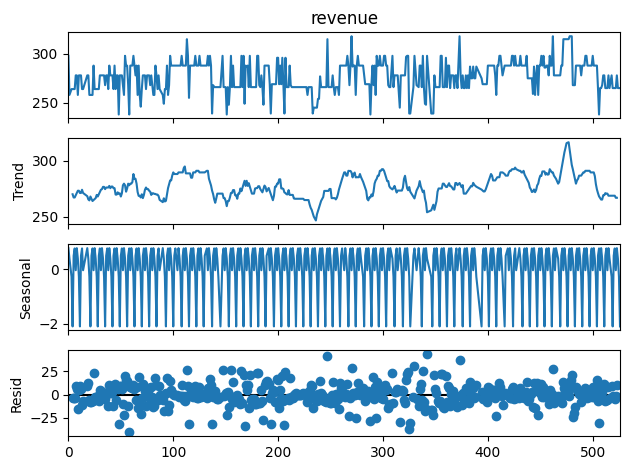

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the data has a daily frequency, set the period accordingly
# Period value will be adjusted according the dataset
result = seasonal_decompose(df['revenue'], model='additive', period=7)  # Assuming weekly seasonality

result.plot()
plt.show()


In [ ]:
# Encoding the categorical variables
df_encoded = pd.get_dummies(df, columns=['color', 'size'], drop_first=True)


In [ ]:
# Defining the features (X) and target (y)
X = df_encoded.drop(['revenue', 'order_date'], axis=1)  # Drop columns not needed
y = df_encoded['revenue']

In [ ]:
# Spliting the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Creating and training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: -6.821210263296962e-13
Coefficients: [ 2.35764168e-15 -4.33680869e-19  1.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.35385225e-16  9.18552158e-17 -8.34066799e-18
  3.03576608e-18 -2.85494154e-15 -1.82508185e-15 -3.13337048e-15
 -3.23886280e-15 -5.50398134e-15 -2.17048995e-15 -4.20155020e-15
 -4.33680869e-19 -1.93205209e-15 -2.51668317e-15  0.00000000e+00
 -1.84754625e-15 -3.85922903e-15 -1.50934594e-15 -2.17942191e-15
 -4.35768897e-15 -7.87395309e-15 -3.03648201e-15 -2.10805313e-15
 -3.38813179e-20 -1.92483857e-15 -1.02988409e-15 -1.53472131e-15
  0.00000000e+00 -4.24053893e-15 -4.71645595e-16 -2.47111982e-15
  3.86651919e-16  2.85400079e-14  1.53787355e-16  1.73525506e-16
  1.34163359e-15 -5.30086374e-16  2.31983599e-16]


In [ ]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Displaying predictions
print("Predictions:", y_pred[:5])


Predictions: [288. 278. 239. 266. 266.]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate different evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 1.4182145917797554e-13
Mean Squared Error (MSE): 3.033713618087276e-26
R² Score: 1.0


In [ ]:
# Import LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare the dataset
X = df_encoded.drop(['revenue', 'order_date', 'sku'], axis=1)  # Features, drop 'sku' column
y = df_encoded['revenue']  # Target variable

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert datasets to LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Train the model
# The early_stopping_rounds parameter is moved inside the lgb.early_stopping callback
lgb_model = lgb.train(params,
                       train_data,
                       valid_sets=[test_data],
                       num_boost_round=1000,
                       callbacks=[lgb.early_stopping(stopping_rounds=50)]) # Using the callback for early stopping

# Predict on the test set
y_pred = lgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"LightGBM - MAE: {mae}, MSE: {mse}, R²: {r2}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's l1: 0.42302
LightGBM - MAE: 0.423020303923918, MSE: 0.7342058307505303, R²: 0.9966638704616158


DEBUG:cmdstanpy:input tempfile: /tmp/tmp69yjx978/m7ae2rfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp69yjx978/visva7lx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72696', 'data', 'file=/tmp/tmp69yjx978/m7ae2rfg.json', 'init=/tmp/tmp69yjx978/visva7lx.json', 'output', 'file=/tmp/tmp69yjx978/prophet_model3pj66yjx/prophet_model-20250113120003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


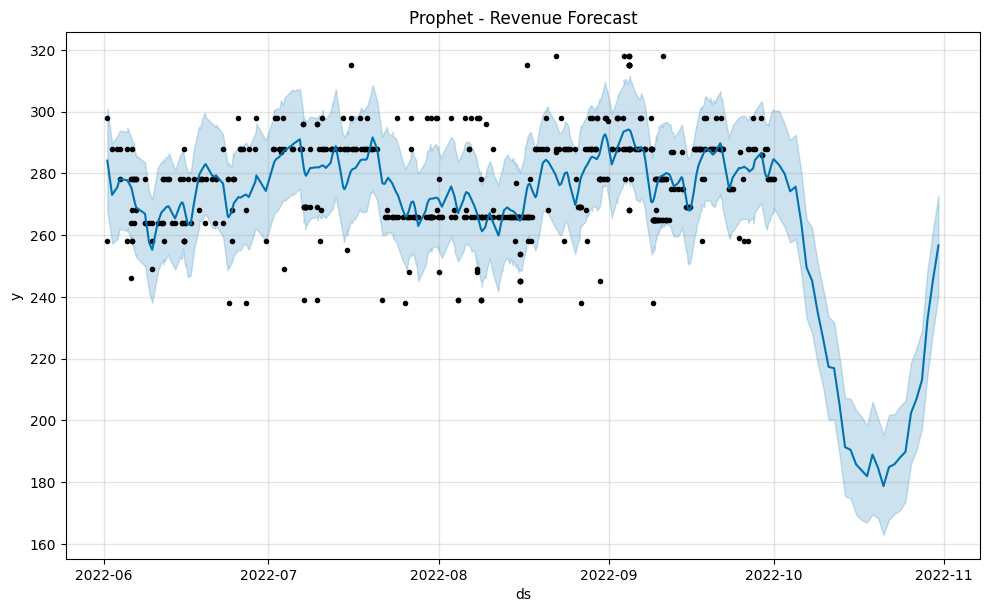

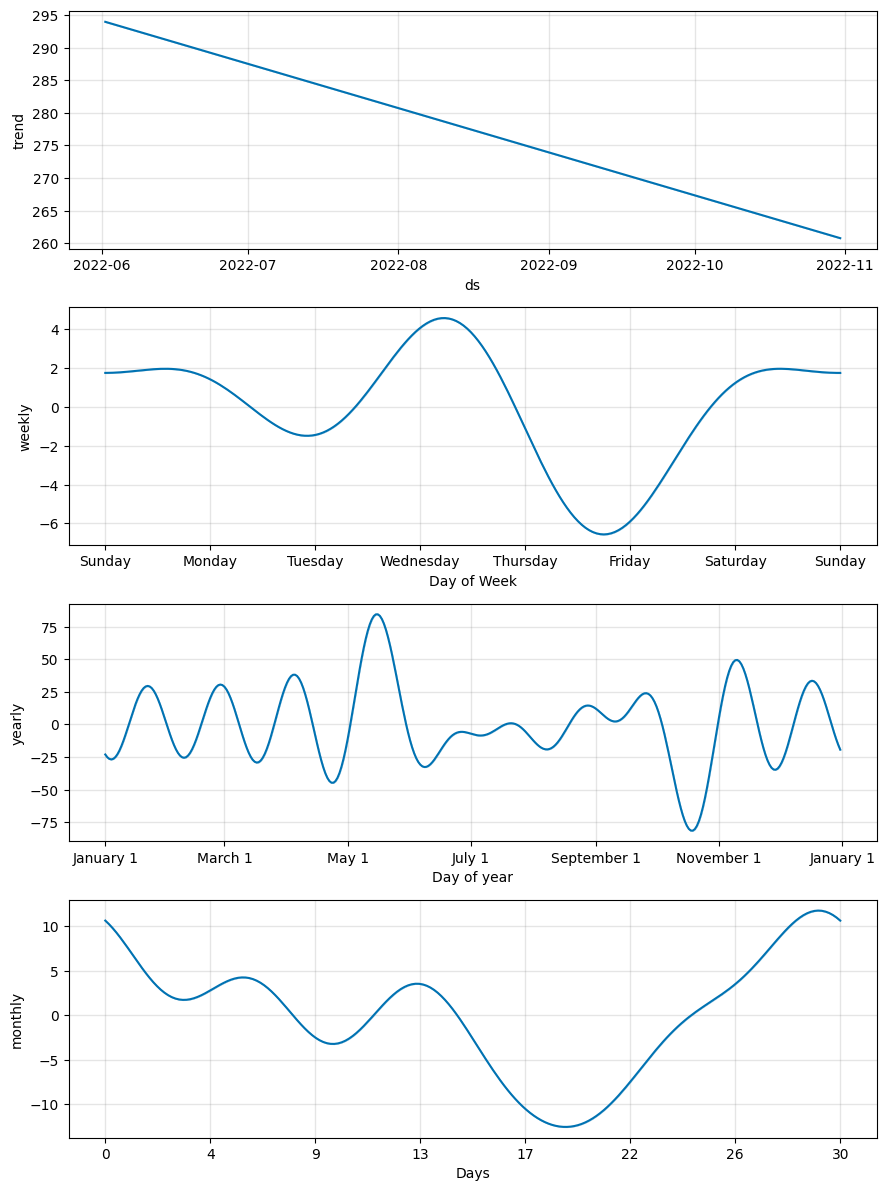

In [ ]:
# Prepare the dataset for Prophet
# Prophet requires columns named 'ds' (datetime) and 'y' (target variable)
df_prophet = df[['order_date', 'revenue']].rename(columns={'order_date': 'ds', 'revenue': 'y'})

# Initialize the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Adding custom seasonality

# Train the model
model.fit(df_prophet)

# Create a future dataframe for forecasting
future = model.make_future_dataframe(periods=30)  # Forecast for the next 30 days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Prophet - Revenue Forecast')
plt.show()

# Plot forecast components (trend, seasonality)
fig_components = model.plot_components(forecast)
plt.show()


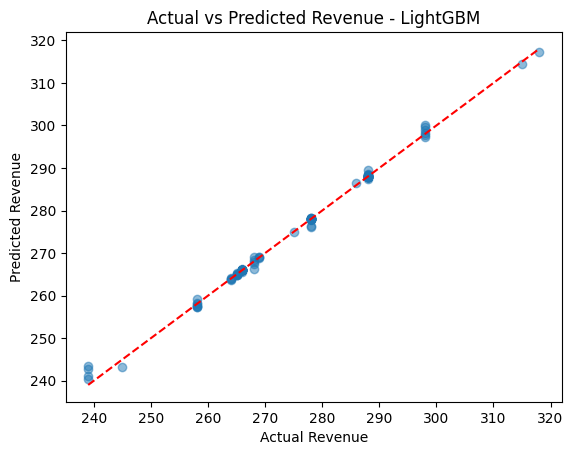

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue - LightGBM")
plt.show()
